# Classification Analysis für Product Quality Prediction

## Projektbeschreibung
Dieses Notebook implementiert eine umfassende Klassifikationsanalyse für die Vorhersage der Produktqualität in einem industriellen IoT-Szenario. 

**Ziel:** Vorhersage der Produktqualität (OK, WARNING, ERROR) basierend auf Sensordaten aus dem Produktionsprozess.

**Datenbasis:** Industrielle Sensordaten mit folgenden Features:
- Temperatur (°C)
- Druck (bar) 
- Vibration (Hz)
- Produktionsgeschwindigkeit (units/min)
- Maschinenlaufzeit (Stunden)

## Notebook-Struktur
1. **Import Required Libraries** - Laden der notwendigen Bibliotheken
2. **Load and Explore Dataset** - Datenladen und erste Exploration  
3. **Data Preprocessing** - Datenvorverarbeitung und Bereinigung
4. **Feature Engineering** - Feature-Erstellung und -Transformation
5. **Model Training** - Training mehrerer Klassifikationsmodelle
6. **Model Evaluation** - Bewertung mit Metriken und Confusion Matrix
7. **Make Predictions** - Vorhersagen auf neuen Daten und Export

## Erwartete Ergebnisse
- Trainierte Klassifikationsmodelle mit Vergleich der Performance
- Confusion Matrix und Classification Reports
- Feature Importance Analyse
- Export der Vorhersagen für weitere Verwendung

In [1]:
# Import Required Libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

# Inline data generation and transformation functions
def generate_classification_data(n_samples=1000):
    """Generate realistic classification data for product quality prediction."""
    np.random.seed(42)
    
    # Generate base features
    temperature = np.random.normal(75, 8, n_samples)
    pressure = np.random.normal(3.5, 0.5, n_samples)
    vibration = np.random.normal(25, 5, n_samples)
    production_speed = np.random.normal(120, 15, n_samples)
    machine_runtime = np.random.exponential(12, n_samples)
    
    # Generate quality based on realistic conditions
    quality_score = (
        (temperature > 80) * 0.3 +
        (pressure < 3.0) * 0.2 +
        (vibration > 30) * 0.25 +
        (production_speed > 140) * 0.15 +
        (machine_runtime > 20) * 0.1 +
        np.random.random(n_samples) * 0.2
    )
    
    # Convert to categorical quality
    quality = ['OK'] * n_samples
    for i in range(n_samples):
        if quality_score[i] > 0.6:
            quality[i] = 'ERROR'
        elif quality_score[i] > 0.35:
            quality[i] = 'WARNING'
    
    return pd.DataFrame({
        'temperature': temperature,
        'pressure': pressure,
        'vibration': vibration,
        'production_speed': production_speed,
        'machine_runtime': machine_runtime,
        'quality': quality
    })

def engineer_features_classification(df):
    """Apply feature engineering for classification tasks."""
    df_transformed = df.copy()
    
    # Create interaction features
    df_transformed['temp_vibration_interaction'] = df_transformed['temperature'] * df_transformed['vibration']
    df_transformed['pressure_speed_interaction'] = df_transformed['pressure'] * df_transformed['production_speed']
    
    # Create derived features
    df_transformed['efficiency_score'] = df_transformed['production_speed'] / (df_transformed['machine_runtime'] + 1)
    df_transformed['stress_indicator'] = (df_transformed['temperature'] / 100) * (df_transformed['vibration'] / 50)
    
    # Create binned features
    runtime_dummies = pd.get_dummies(pd.cut(df_transformed['machine_runtime'], 
                                          bins=[0, 10, 20, float('inf')], 
                                          labels=['short', 'medium', 'long']), 
                                   prefix='runtime').astype(int)
    df_transformed = pd.concat([df_transformed, runtime_dummies], axis=1)
    
    # Create rolling statistics (simulate time-series features)
    df_transformed = df_transformed.sort_values('temperature').reset_index(drop=True)
    df_transformed['temp_rolling_mean'] = df_transformed['temperature'].rolling(window=5, min_periods=1).mean()
    df_transformed['vibration_rolling_std'] = df_transformed['vibration'].rolling(window=3, min_periods=1).std().fillna(0)
    
    return df_transformed

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

print("Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

Libraries imported successfully!
Working directory: c:\dev\automatisierung\automatisierungstechnik\classification


Loading classification data...
Dataset shape: (1000, 6)
Columns: ['temperature', 'pressure', 'vibration', 'production_speed', 'machine_runtime', 'quality']

First 5 rows:
   temperature  pressure  vibration  production_speed  machine_runtime  \
0    78.973713  4.199678  21.624109         91.382887         7.963480   
1    73.893886  3.962317  24.277407        107.094225         1.071261   
2    80.181508  3.529815  21.037900        113.795917        43.105995   
3    87.184239  3.176532  23.460192        148.315315         8.757994   
4    73.126773  3.849112  15.531927        128.348297        11.428806   

   quality  
0       OK  
1       OK  
2  WARNING  
3  WARNING  
4       OK  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature       1000 non-null   float64
 1   pressure          1000 non-null   float6

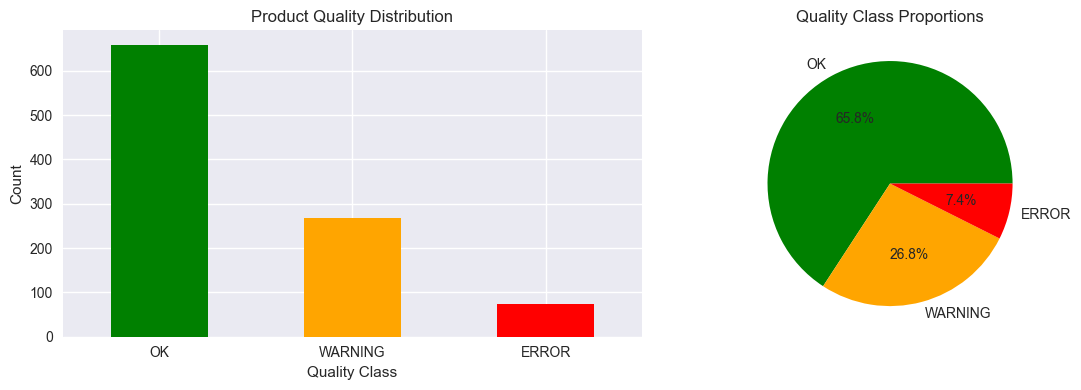

In [2]:
# Load and Explore Dataset
# Load classification data using inline function
print("Loading classification data...")
df = generate_classification_data(n_samples=1000)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

# Check class distribution
print("\nClass distribution:")
print(df['quality'].value_counts())
print("\nClass proportions:")
print(df['quality'].value_counts(normalize=True).round(3))

# Visualize class distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['quality'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Product Quality Distribution')
plt.xlabel('Quality Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(df['quality'].value_counts().values, 
        labels=df['quality'].value_counts().index,
        autopct='%1.1f%%',
        colors=['green', 'orange', 'red'])
plt.title('Quality Class Proportions')

plt.tight_layout()
plt.show()

In [ ]:
# Data Preprocessing
print("=== Data Preprocessing ===\n")

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Explore feature distributions by class
numeric_features = ['temperature', 'pressure', 'vibration', 'production_speed', 'machine_runtime']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(numeric_features):
    sns.boxplot(data=df, x='quality', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature.replace("_", " ").title()} by Quality')
    axes[i].tick_params(axis='x', rotation=45)

# Remove the empty subplot
axes[5].remove()

plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(10, 8))
# Create numeric dataframe for correlation
df_numeric = df.copy()
le = LabelEncoder()
df_numeric['quality_encoded'] = le.fit_transform(df['quality'])

corr_matrix = df_numeric[numeric_features + ['quality_encoded']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("Quality encoding:")
for i, quality in enumerate(le.classes_):
    print(f"  {quality}: {i}")

# Prepare for modeling
print("\nPreparing data for modeling...")
X = df[numeric_features]
y = df['quality']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Target classes: {y.unique()}")

In [ ]:
# Feature Engineering
print("=== Feature Engineering ===\n")

# Apply feature engineering using our transformer
print("Applying feature engineering...")
df_transformed = transformer.engineer_features_classification(df.copy())

print(f"Original features: {len(numeric_features)}")
print(f"After feature engineering: {df_transformed.shape[1] - 1}")  # -1 for target

# Get new feature names (excluding target)
feature_columns = [col for col in df_transformed.columns if col != 'quality']
new_features = [col for col in feature_columns if col not in numeric_features]

print(f"New features added: {len(new_features)}")
print("\nNew feature columns:")
for feature in new_features:
    print(f"  - {feature}")

# Prepare final dataset
X_engineered = df_transformed[feature_columns]
y = df_transformed['quality']

print(f"\nFinal feature matrix shape: {X_engineered.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in test set:")
print(y_test.value_counts())

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")

In [ ]:
# Model Training
print("=== Model Training ===\n")

# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'model': model
    }
    
    print(f"{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print()

# Results comparison
print("Model Comparison:")
results_df = pd.DataFrame({
    name: {metric: values[metric] for metric in ['accuracy', 'precision', 'recall', 'f1_score']}
    for name, values in results.items()
}).round(4)
print(results_df)

In [ ]:
# Model Evaluation
print("=== Model Evaluation ===\n")

# Create confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, result) in enumerate(results.items()):
    y_pred = result['predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['ERROR', 'OK', 'WARNING'],
                yticklabels=['ERROR', 'OK', 'WARNING'],
                ax=axes[i])
    axes[i].set_title(f'{name}\nAccuracy: {result["accuracy"]:.4f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed classification reports
for name, result in results.items():
    print(f"\n{name} - Detailed Classification Report:")
    print("="*50)
    print(classification_report(y_test, result['predictions']))

# Feature importance for Random Forest
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features (Random Forest):")
    print(feature_importance.head(10))

# Class-wise performance analysis
print("\n" + "="*60)
print("CLASS-WISE PERFORMANCE ANALYSIS")
print("="*60)

class_names = ['ERROR', 'OK', 'WARNING']
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])

for class_name in class_names:
    print(f"\n{class_name} Class Performance:")
    for name, result in results.items():
        y_pred = result['predictions']
        class_precision = precision_score(y_test, y_pred, labels=[class_name], average=None)[0]
        class_recall = recall_score(y_test, y_pred, labels=[class_name], average=None)[0]
        class_f1 = f1_score(y_test, y_pred, labels=[class_name], average=None)[0]
        
        print(f"  {name:20} - Precision: {class_precision:.4f}, Recall: {class_recall:.4f}, F1: {class_f1:.4f}")

print(f"\nBest performing model overall: {best_model_name} (F1-Score: {results[best_model_name]['f1_score']:.4f})")

In [ ]:
# Make Predictions
print("=== Make Predictions ===\n")

# Select best model based on F1-score
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
best_model = results[best_model_name]['model']

print(f"Best performing model: {best_model_name}")
print(f"Best F1-Score: {results[best_model_name]['f1_score']:.4f}")

# Generate new data for prediction
print("\nGenerating new data for prediction...")
new_data = data_manager.generate_classification_data(n_samples=100)

# Apply same transformations
new_data_transformed = transformer.engineer_features_classification(new_data)
X_new = new_data_transformed[feature_columns]

# Make predictions with best model
if best_model_name in ['Logistic Regression', 'SVM']:
    X_new_scaled = scaler.transform(X_new)
    predictions = best_model.predict(X_new_scaled)
    prediction_probabilities = best_model.predict_proba(X_new_scaled)
else:
    predictions = best_model.predict(X_new)
    prediction_probabilities = best_model.predict_proba(X_new)

# Create prediction results
prediction_results = new_data.copy()
prediction_results['predicted_quality'] = predictions

# Add prediction probabilities
prob_df = pd.DataFrame(prediction_probabilities, columns=[f'prob_{cls}' for cls in best_model.classes_])
prediction_results = pd.concat([prediction_results.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)

# Calculate prediction confidence (max probability)
prediction_results['prediction_confidence'] = prediction_probabilities.max(axis=1)

# Prediction accuracy on new data
correct_predictions = (prediction_results['quality'] == prediction_results['predicted_quality']).sum()
accuracy_new = correct_predictions / len(prediction_results)

print(f"\nGenerated {len(prediction_results)} predictions")
print(f"Accuracy on new data: {accuracy_new:.4f}")
print(f"Mean prediction confidence: {prediction_results['prediction_confidence'].mean():.4f}")

# Analyze prediction distribution
print("\nPrediction distribution:")
print(prediction_results['predicted_quality'].value_counts())

print("\nActual vs Predicted on new data:")
confusion_new = pd.crosstab(prediction_results['quality'], 
                           prediction_results['predicted_quality'], 
                           margins=True)
print(confusion_new)

# Export predictions
output_file = 'classification_predictions.csv'
export_columns = ['temperature', 'pressure', 'vibration', 'production_speed', 
                 'machine_runtime', 'quality', 'predicted_quality', 
                 'prediction_confidence'] + [f'prob_{cls}' for cls in best_model.classes_]

prediction_export = prediction_results[export_columns]
prediction_export.to_csv(output_file, index=False)
print(f"\nPredictions exported to: {output_file}")

# Show sample predictions
print("\nSample predictions:")
sample_display = prediction_results[['temperature', 'pressure', 'vibration', 
                                   'quality', 'predicted_quality', 
                                   'prediction_confidence']].head(10).round(4)
print(sample_display)

# Summary statistics
print("\n" + "="*60)
print("CLASSIFICATION ANALYSIS SUMMARY")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"Test F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"New Data Accuracy: {accuracy_new:.4f}")
print(f"Total Features Used: {len(feature_columns)}")
print(f"Predictions Exported: {len(prediction_results)} samples")
print(f"Output File: {output_file}")

print("\n=== Classification Analysis Complete ===")